# Eyesense

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

-Normal (N),
-Diabetes (D),
-Glaucoma (G),
-Cataract (C),
-Age related Macular Degeneration (A),
-Hypertension (H),
-Pathological Myopia (M),
-Other diseases/abnormalities (O)

In [1]:
from tensorflow.keras import layers, models, optimizers, callbacks # type: ignore
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2 # type: ignore
import pathlib
from sklearn.metrics import classification_report
from tensorflow.keras.applications import Xception
from collections import Counter
import numpy as np

2025-03-21 01:14:28.877803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 01:14:29.141192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742519669.247428  392559 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742519669.277362  392559 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742519669.475062  392559 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2, ax3 = axs
    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 1.8)
    ax1.autoscale()
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.4, 1.)
    ax2.autoscale()
    ax2.set_title('Accuracy')
    ax2.legend()

    ax3.plot(history.history['recall'], label='train recall'  + exp_name)
    ax3.plot(history.history['val_recall'], label='val recall'  + exp_name)
    #ax2.set_ylim(0.4, 1.)
    ax3.autoscale()
    ax3.set_title('Recall')
    ax3.legend()

    f.savefig("Xception-02.png")
    
    return (ax1, ax2, ax3)

# Preprocess images

In [3]:
batch_size = 32
img_height = 299
img_width  = 299

#Adjust the path according to your machine
data_dir_train = pathlib.Path('../data_train/')
data_dir_val = pathlib.Path('../data_val/')
data_dir_test  = pathlib.Path('../data_test/')


train_ds = image_dataset_from_directory(
            data_dir_train,
            image_size=(img_height, img_width),
            batch_size=batch_size)

val_ds = image_dataset_from_directory(
            data_dir_val,
            image_size=(img_height, img_width),
            batch_size=batch_size)

test_ds = image_dataset_from_directory(
              data_dir_test,
              image_size=(img_height, img_width),
              batch_size=batch_size)

Found 10197 files belonging to 7 classes.


W0000 00:00:1742519680.970106  392559 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 1133 files belonging to 7 classes.
Found 451 files belonging to 7 classes.


We can try do decrease the size of majoritary classes in the training dataset

In [4]:
for image_batch, labels_batch in train_ds:
  print(f"👉The shape of each train batch is {image_batch.shape}")
  print(f"  The shape of each target batch is {labels_batch.shape}")
  break

👉The shape of each train batch is (32, 299, 299, 3)
  The shape of each target batch is (32,)


# Normalizing the images

In [5]:
train_ds.class_names

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal']

In [6]:
#Normalization of the image tensors
normalization_layer =   layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds   =   val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds  =  test_ds.map(lambda x, y: (normalization_layer(x), y))

In [7]:
# Improve performance with prefetching
#normalized_train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
#normalized_val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

# Create weights

In [8]:
# Extract label counts
label_counts = Counter()
for _, labels in train_ds:  # Iterate through the batches
    label_counts.update(labels.numpy())  # Count occurrences of each label

# Display counts for each category
class_weight = {}

n_samples = sum(label_counts.values())
for label, count_per_label in label_counts.items():
    class_weight[int(label)] = float((n_samples/count_per_label)/7)
    print(f"Category {label}: {count_per_label} images")

class_weight

Category 4: 744 images
Category 3: 1648 images
Category 6: 2070 images
Category 1: 1536 images
Category 2: 1159 images
Category 0: 1696 images
Category 5: 1344 images


2025-03-21 01:14:56.137251: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{4: 1.9579493087557602,
 3: 0.8839285714285714,
 6: 0.7037267080745341,
 1: 0.9483816964285714,
 2: 1.2568716874152595,
 0: 0.8589117250673854,
 5: 1.0838647959183674}

# Creating a model

In [9]:
# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global Average Pooling replaces the fully connected layers
x = layers.Dropout(0.5)(x)  # Dropout for regularization
x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(7, activation='softmax')(x)  # Output layer for 7 classes

# Create the full model
model = models.Model(inputs=base_model.input, outputs=predictions)


In [10]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

In [11]:
def preprocess_data(image, label):
    num_classes = 7  # Replace with your actual number of classes
    label = tf.one_hot(label, depth=num_classes)  # Convert to one-hot encoding
    return image, label

# Apply preprocessing to the dataset
processed_train_ds = normalized_train_ds.map(preprocess_data)
processed_val_ds   = normalized_val_ds.map(preprocess_data)


In [12]:

model.compile(
    optimizer= optimizers.Adam(learning_rate=lr_schedule),
    loss= tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

es = callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [13]:
for image_batch, labels_batch in processed_train_ds:
  print(f"👉The shape of each train batch is {image_batch.shape}")
  print(f"  The shape of each target batch is {labels_batch.shape}")
  break

👉The shape of each train batch is (32, 299, 299, 3)
  The shape of each target batch is (32, 7)


In [14]:
history = model.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs = 100,
   # class_weight = class_weight,  #We don't use this when we are using CategoricalFocalCrossentropy as loss function
    steps_per_epoch=len(processed_train_ds),
    validation_steps=len(processed_val_ds),
    callbacks = [es],
    verbose = 1
)

Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.4818 - loss: 1.3456 - recall: 0.3100 - val_accuracy: 0.5931 - val_loss: 1.0892 - val_recall: 0.2056
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.5885 - loss: 1.0521 - recall: 0.4122 - val_accuracy: 0.5163 - val_loss: 1.1769 - val_recall: 0.2418
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.6096 - loss: 0.9823 - recall: 0.4597 - val_accuracy: 0.5525 - val_loss: 1.1330 - val_recall: 0.2083
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.6290 - loss: 0.9250 - recall: 0.4770 - val_accuracy: 0.5516 - val_loss: 1.1064 - val_recall: 0.2251
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.6493 - loss: 0.8865 - recall: 0.5018 - val_accuracy: 0.5207 - val_loss: 1.1689 - val_recall: 0.2083
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.6627 - loss: 0.8509 - recall: 0.5278 - val_accuracy: 0.5269 - val_loss: 1.1478 - val_recall:

# Predicting results

In [19]:
model.save_weights("../saved_model/Xception-02.weights.h5") 

In [20]:
model.save('../saved_model/model_Xception-02.keras')

In [21]:
import numpy as np
y_true = np.concatenate([y.numpy() for _, y in normalized_test_ds], axis=0)
y_pred = model.predict(normalized_test_ds)
y_pred_class = np.argmax(y_pred, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


In [22]:
#y_true_class = np.argmax(y_true, axis=1)
print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.03      0.04      0.04        23
           1       0.03      0.05      0.04        21
           2       0.27      0.16      0.20       128
           3       0.03      0.05      0.04        22
           4       0.00      0.00      0.00        10
           5       0.05      0.06      0.05        18
           6       0.53      0.58      0.55       229

    accuracy                           0.35       451
   macro avg       0.14      0.13      0.13       451
weighted avg       0.35      0.35      0.35       451



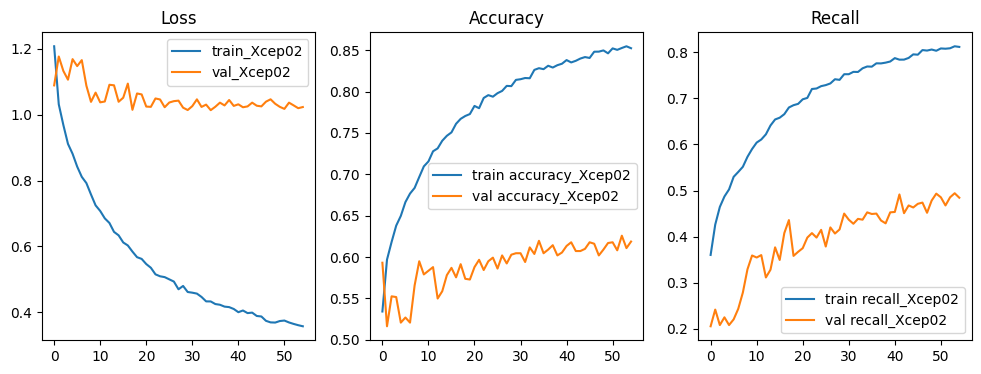

In [23]:
ax1, ax2, ax3 = plot_history(history, exp_name= 'Xcep02')

In [31]:
print(y_pred_class[0:10])
print( y_true[0:10])

[2 6 6 6 6 2 6 3 0 1]
[3 6 6 6 6 6 2 3 2 2]
